#### Master Thesis 2024 - Diksha Acharya

# 7 - Heat index Heat maps
## Master Thesis 2024
---

7.1 - Imports and tables

In [1]:
# Import 
import geopandas as gpd
import pandas as pd
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.colors as mcolors
import os
from shapely.geometry import Point
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.colors import LinearSegmentedColormap

In [2]:
# Indian states shapefile
shapefile_path = "Indian_States"
Indian_states = gpd.read_file(shapefile_path)

In [3]:
# state capitals
capitals_df = pd.DataFrame({
    "State": [
        "Andhra Pradesh", "Arunachal Pradesh", "Assam", "Bihar", "Chhattisgarh",
        "Goa", "Gujarat", "Haryana", "Himachal Pradesh","Jammu Kashmir", "Jharkhand",
        "Karnataka", "Kerala", "Madhya Pradesh", "Maharashtra", "Manipur",
        "Meghalaya", "Mizoram", "Nagaland", "Odisha", "Punjab",
        "Rajasthan", "Sikkim", "Tamil Nadu", "Telangana", "Tripura",
        "Uttar Pradesh", "Uttarakhand", "West Bengal"
    ],
    "Capital": [
        "Amaravati", "Itanagar", "Dispur", "Patna", "Raipur",
        "Panaji", "Gandhinagar", "Chandigarh", "Shimla", "Jammu", "Ranchi",
        "Bengaluru", "Thiruvananthapuram", "Bhopal", "Mumbai", "Imphal",
        "Shillong", "Aizawl", "Kohima", "Bhubaneswar", "Chandigarh",
        "Jaipur", "Gangtok", "Chennai", "Hyderabad", "Agartala",
        "Lucknow", "Dehradun", "Kolkata"
    ],
    "Latitude": [
        14.9062, 28.0844, 26.5438, 25.5941, 21.2514,
        15.4909, 23.2156, 29.5333, 32.1048, 34.5, 23.3441,
        13.9716, 8.9241, 23.2599, 19.0760, 24.8170,
        25.5788, 22.7271, 25.9751, 20.2961, 30.7333,
        26.9124, 27.3314, 11.0827, 17.3850, 23.8315,
        26.8467, 30.3165, 22.5726
    ],
    "Longitude": [
        79.6480, 93.6053, 91.7898, 85.1376, 81.6296,
        73.8317, 72.6369, 76.5794, 77.1734, 77, 85.3096,
        75.6946, 76.5366, 77.4126, 74.8777, 93.9368,
        91.8933, 92.7176, 94.1086, 84.8245, 75.7794,
        73.7873, 88.6065, 78.2707, 78.8867, 91.2868,
        80.9462, 79.2322, 88.3639
    ]
})

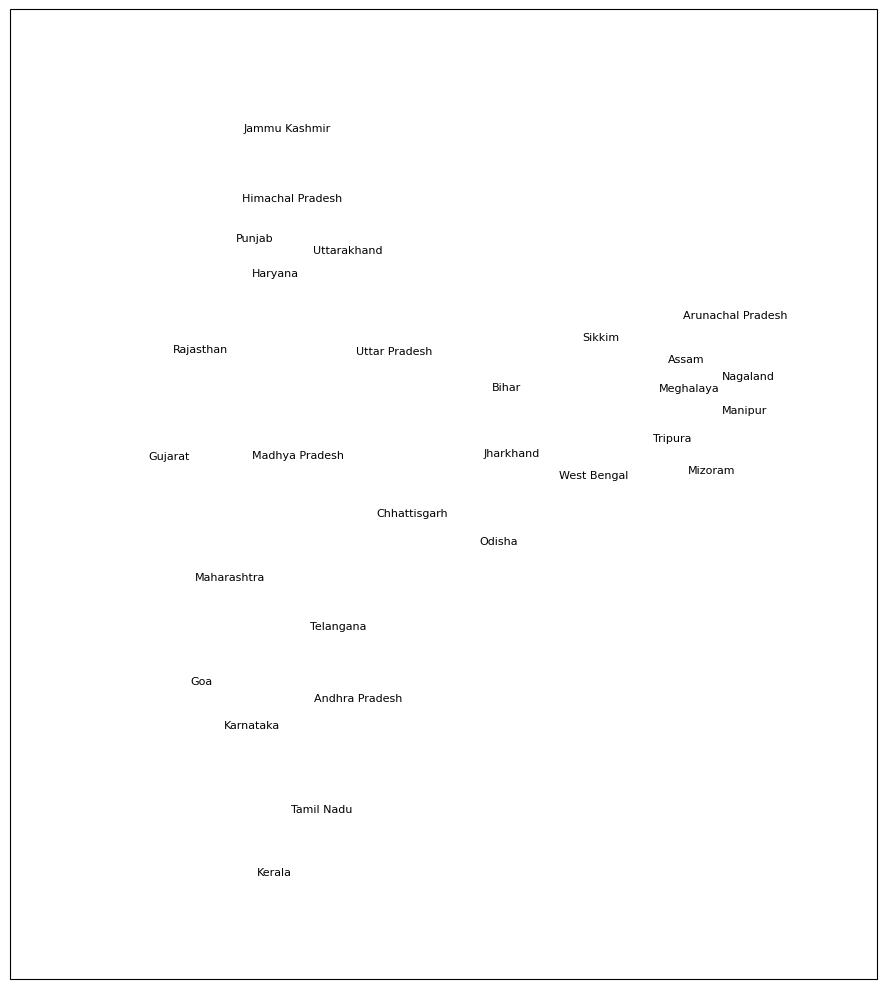

In [4]:
# Plotting the heatmap
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': ccrs.PlateCarree()})

# Add map features
ax.add_feature(cfeature.BORDERS, linestyle=":", edgecolor="white")
ax.add_feature(cfeature.COASTLINE, edgecolor="white")
ax.add_feature(cfeature.LAND, facecolor="white")

# Add Indian states boundaries
Indian_states.boundary.plot(ax=ax, edgecolor='white', linewidth=0.8)

# Plot the heatmap
lon, lat = np.meshgrid(capitals_df['Longitude'], capitals_df['Latitude'])

# Plot city points and labels
for _, row in capitals_df.iterrows():
    #ax.plot(row["Longitude"], row["Latitude"], 'o', color='black', transform=ccrs.PlateCarree(), zorder=5)
    ax.text(row["Longitude"], row["Latitude"], row["State"],
            transform=ccrs.PlateCarree(), fontsize=8, color='black',
            horizontalalignment='center', verticalalignment='center', zorder=10)

# Add title and labels
plt.xlabel("Longitude")
plt.ylabel("Latitude")

# Show the plot
plt.tight_layout()
plt.show()

Color codeing:

Proctor, T. C. (2016, April 18). Named colors in matplotlib [Forum post]. Stack Overflow. https://stackoverflow.com/q/22408237

7.1.1 - HI valid daily maximim

In [5]:
# daily HI file
file_HI_daily = "India_HI_adjustment_daily_stats.nc"
HI_daily = xr.open_dataset(file_HI_daily)
HI_daily

<xarray.Dataset>
Dimensions:       (longitude: 120, latitude: 124, time: 30681)
Coordinates:
  * longitude     (longitude) float32 68.0 68.25 68.5 68.75 ... 97.25 97.5 97.75
  * latitude      (latitude) float32 38.0 37.75 37.5 37.25 ... 8.0 7.75 7.5 7.25
  * time          (time) datetime64[ns] 1940-01-01 1940-01-02 ... 2023-12-31
Data variables:
    daily_max_HI  (time, latitude, longitude) float32 ...
    daily_min_HI  (time, latitude, longitude) float32 ...
    daily_avg_HI  (time, latitude, longitude) float32 ...

7.1.2 - T° daily max data

In [6]:
# daily T file
file_T_daily = "India_T_daily_stats.nc"
T_daily = xr.open_dataset(file_T_daily)
T_daily

<xarray.Dataset>
Dimensions:         (longitude: 120, latitude: 124, time: 30681)
Coordinates:
  * longitude       (longitude) float32 68.0 68.25 68.5 ... 97.25 97.5 97.75
  * latitude        (latitude) float32 38.0 37.75 37.5 37.25 ... 7.75 7.5 7.25
  * time            (time) datetime64[ns] 1940-01-01 1940-01-02 ... 2023-12-31
Data variables:
    daily_max_temp  (time, latitude, longitude) float32 ...
    daily_min_temp  (time, latitude, longitude) float32 ...
    daily_avg_temp  (time, latitude, longitude) float32 ...

---
7.2 - WMO heatwave definition based on T max vs based on HI daily max

"when the daily maximum temperature exceeds the average maximum temperature by 5 °C for more than five consecutive days, the normal period being 1961-1990"”(Rajeevan et al., 2023)

In [27]:
# Extract 1961–1990 baseline period with T
baseline_wmo = T_daily['daily_max_temp'].sel(time=slice('1961-01-01', '1990-12-31'))

# Group by day-of-year and take the mean (climatology)
baseline_wmo_average_max_T = baseline_wmo.mean(dim='time')

In [7]:
# Extract 1961–1990 baseline period with HI
baseline_wmo_HI = HI_daily['daily_max_HI'].sel(time=slice('1961-01-01', '1990-12-31'))

# Group by day-of-year and take the mean (climatology)
baseline_wmo_average_max_HI = baseline_wmo_HI.mean(dim='time')

In [28]:
diff_T_wmo = T_daily['daily_max_temp'] - baseline_wmo_average_max_T

In [8]:
diff_HI_wmo = HI_daily['daily_max_HI'] - baseline_wmo_average_max_HI

In [29]:
# Binary heatwave condition with T
heatwave_bool_wmo_T = (diff_T_wmo >= 5).astype(int)
heatwave_bool_wmo_T

<xarray.DataArray 'daily_max_temp' (time: 30681, latitude: 124, longitude: 120)>
array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
...
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]])
Coordinates:
  * longitude  (longitude) float32 68.0 68.25 68.5 68.75 ... 97.25 97.5 97.75
  * latitude   (latitude) float32 38.0 37.75 37.5 37.25 ... 8.0 7.75 7.5 7.25
  * time       (time) datetime64[ns] 1940-01-01 1940-01-02 ... 2023-12-31

In [9]:
# Binary heatwave condition with HI
heatwave_bool_wmo_HI = (diff_HI_wmo >= 5).astype(int)
heatwave_bool_wmo_HI

<xarray.DataArray 'daily_max_HI' (time: 30681, latitude: 124, longitude: 120)>
array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
...
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]])
Coordinates:
  * longitude  (longitude) float32 68.0 68.25 68.5 68.75 ... 97.25 97.5 97.75
  * latitude   (latitude) float32 38.0 37.75 37.5 37.25 ... 8.0 7.75 7.5 7.25
  * time       (time) datetime64[ns] 1940-01-01 1940-01-02 ... 2023-12-31

In [10]:
# WMO heatwave event count
def count_heatwave_events_wmo(data, min_streak=6): # more than 5 days
    def count_events(arr):
        count = 0
        streak = 0
        for val in arr:
            if val:
                streak += 1
            else:
                if streak >= min_streak:
                    count += 1
                streak = 0
        if streak >= min_streak:
            count += 1
        return count

    return np.apply_along_axis(count_events, axis=0, arr=data.values)

7.2.1 - T daily max

In [30]:
# Select the specific period on T
selected_period = heatwave_bool_wmo_T.sel(time=slice('2000-01-01', '2023-12-31'))

wmo_heatwaves_T = count_heatwave_events_wmo(selected_period, min_streak=6)
print(wmo_heatwaves_T.max())

196


196


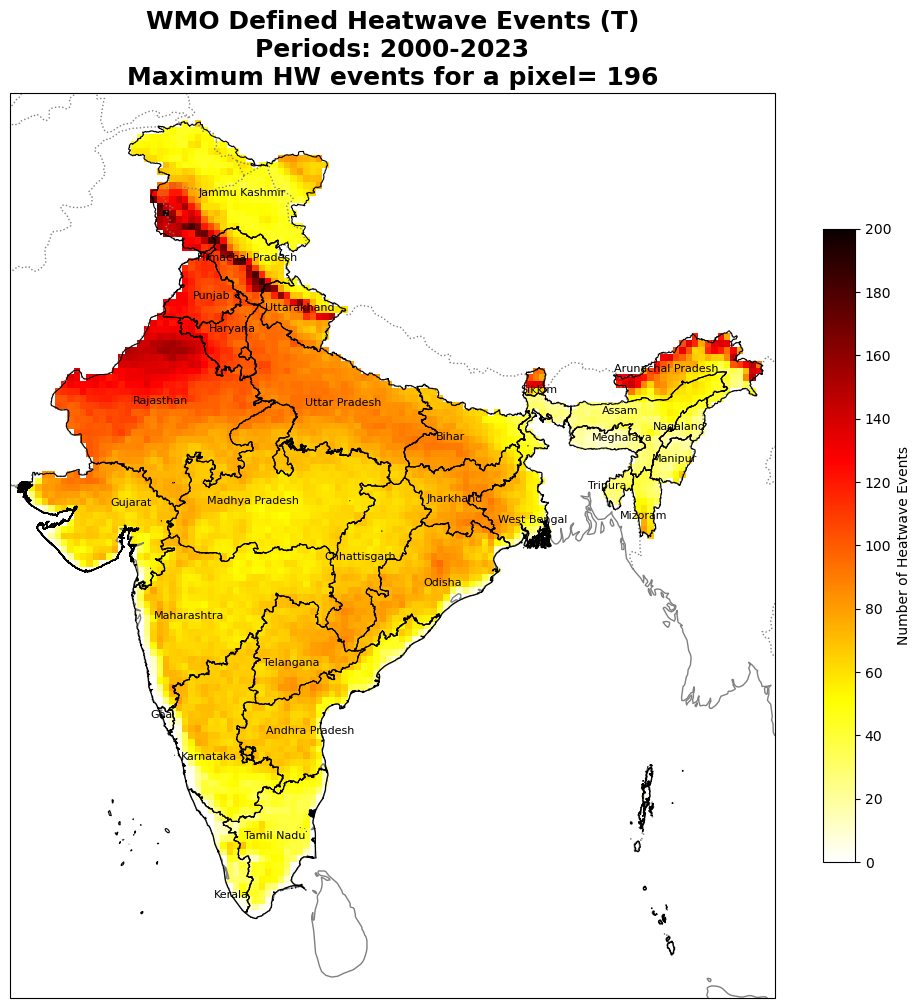

In [35]:
# Select the specific period on T
selected_period = heatwave_bool_wmo_T.sel(time=slice('2000-01-01', '2023-12-31'))

wmo_heatwaves_T = count_heatwave_events_wmo(selected_period, min_streak=6)
print(wmo_heatwaves_T.max())

fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': ccrs.PlateCarree()})
#facecolor='none')

# Map features
#ax.set_facecolor('none')
ax.add_feature(cfeature.BORDERS, linestyle=":", edgecolor="gray")
ax.add_feature(cfeature.COASTLINE, edgecolor="gray")
ax.add_feature(cfeature.LAND, facecolor="white")

# Add Indian states boundaries (if you have the shape file)
Indian_states.boundary.plot(ax=ax, edgecolor='black', linewidth=0.8)


# Longitude & Latitude for mesh
lon, lat = np.meshgrid(T_daily['longitude'], T_daily['latitude'])

# Plot the data
cmap = plt.cm.hot_r
heatmap = ax.pcolormesh(lon, lat, wmo_heatwaves_T, cmap=cmap, shading='auto', vmin=0, vmax = 200)

# Colorbar
cbar = plt.colorbar(heatmap, ax=ax, orientation="vertical", shrink=0.7, pad=0.05)
cbar.set_label(f"Number of Heatwave Events")
cbar.set_ticks(np.linspace(0, 200, num=11))


# Plot city points and labels
for _, row in capitals_df.iterrows():
    #ax.plot(row["Longitude"], row["Latitude"], 'o', color='black', transform=ccrs.PlateCarree(), zorder=5)
    ax.text(row["Longitude"], row["Latitude"], row["State"],
            transform=ccrs.PlateCarree(), fontsize=8, color='black',
            horizontalalignment='center', verticalalignment='center', zorder=10)

# Add title and labels
plt.title(f"WMO Defined Heatwave Events (T)\nPeriods: 2000-2023\nMaximum HW events for a pixel= {wmo_heatwaves_T.max()}", fontsize=18, fontweight = 'bold')
plt.xlabel("Longitude")
plt.ylabel("Latitude")


plt.tight_layout()
plt.show()


7.2.2 - HI daily max

In [11]:
# Count WMO-defined heatwave events based on HI
wmo_heatwaves_HI = count_heatwave_events_wmo(heatwave_bool_wmo_HI, min_streak=6)
wmo_heatwaves_HI.max()

564

In [16]:
# Select the specific period on HI
selected_period = heatwave_bool_wmo_HI.sel(time=slice('1940-01-01', '1969-12-31'))

wmo_heatwaves_HI = count_heatwave_events_wmo(selected_period, min_streak=6)
print(wmo_heatwaves_HI.max())

170


170


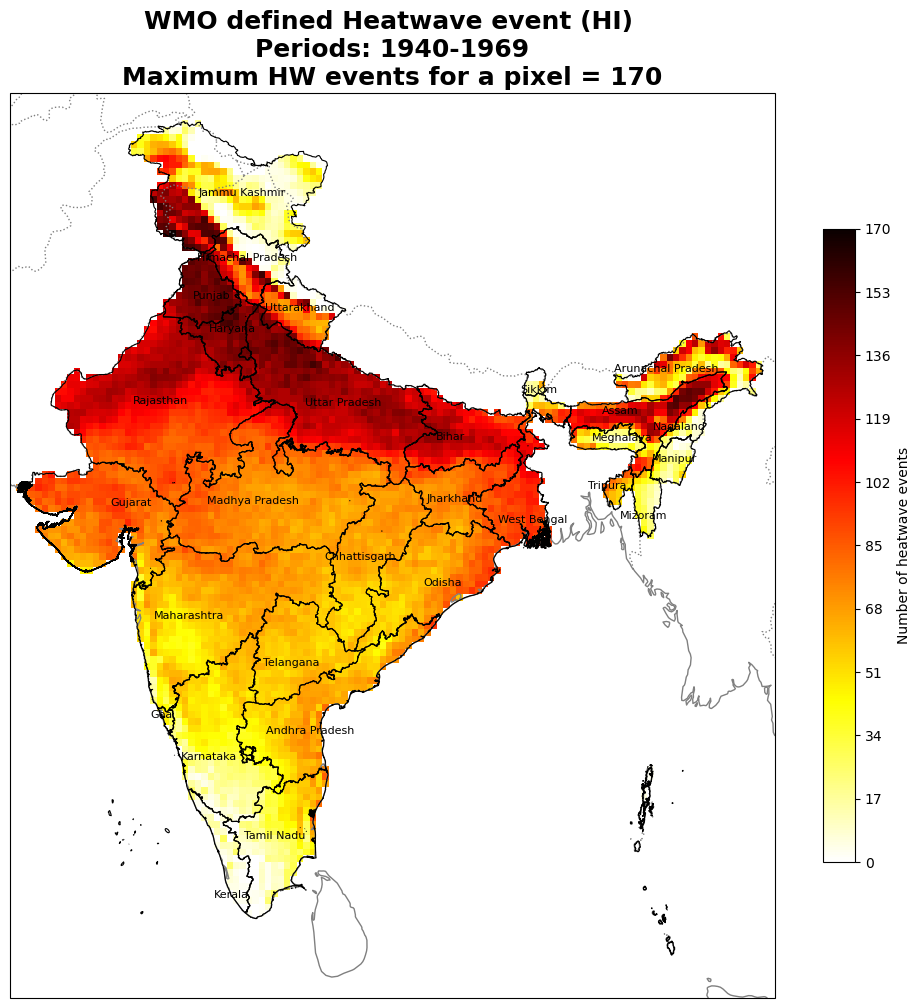

In [32]:
# Select the specific period on HI
selected_period = heatwave_bool_wmo_HI.sel(time=slice('1940-01-01', '1969-12-31'))

wmo_heatwaves_HI = count_heatwave_events_wmo(selected_period, min_streak=6)
print(wmo_heatwaves_HI.max())

fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': ccrs.PlateCarree()}, facecolor='none')

# Map features
ax.set_facecolor('none')
ax.add_feature(cfeature.BORDERS, linestyle=":", edgecolor="gray")
ax.add_feature(cfeature.COASTLINE, edgecolor="gray")
ax.add_feature(cfeature.LAND, facecolor="white")

# Add Indian states boundaries (if you have the shape file)
Indian_states.boundary.plot(ax=ax, edgecolor='black', linewidth=0.8)


# Longitude & Latitude for mesh
lon, lat = np.meshgrid(T_daily['longitude'], T_daily['latitude'])

# Plot the data
cmap = plt.cm.hot_r
heatmap = ax.pcolormesh(lon, lat, wmo_heatwaves_HI, cmap=cmap, shading='auto', vmin=0, vmax = 170)

# Colorbar
cbar = plt.colorbar(heatmap, ax=ax, orientation="vertical", shrink=0.7, pad=0.05)
#cbar.set_label(f"Heatwave Frequency (% of Maximum ={wmo_heatwaves_HI.max()}) HW events")
cbar.set_label(f"Number of heatwave events")
cbar.set_ticks(np.linspace(0,170, num=11))

# Plot city points and labels
for _, row in capitals_df.iterrows():
    #ax.plot(row["Longitude"], row["Latitude"], 'o', color='black', transform=ccrs.PlateCarree(), zorder=5)
    ax.text(row["Longitude"], row["Latitude"], row["State"],
            transform=ccrs.PlateCarree(), fontsize=8, color='black',
            horizontalalignment='center', verticalalignment='center', zorder=10)

# Add title and labels
plt.title(f"WMO defined Heatwave event (HI) \nPeriods: 1940-1969\nMaximum HW events for a pixel = {wmo_heatwaves_HI.max()}", fontsize=18, fontweight = 'bold')
plt.xlabel("Longitude")
plt.ylabel("Latitude")


plt.tight_layout()
plt.show()


---
7.3 - IMD general heatwave definition

If the “actual maximum temperature” reaches 45°C or more for at least 2 days, IMD considers this as an occurrence of heatwave, and severe heatwave if the “actual maximum temperature” exceeds 47°C for at least 2 days and recorded by 2 IMD stations (Home | India Meteorological Department, 2021; Deoras, 2016).  


In [21]:
# Binary heatwave conditions on T
heatwave_bool_45_T = (T_daily['daily_max_temp'] >= 45).astype(int)
heatwave_bool_47_T = (T_daily['daily_max_temp'] >= 47).astype(int)

In [22]:
# Binary heatwave conditions based on HI
heatwave_bool_45_HI = (HI_daily['daily_max_HI'] >= 45).astype(int)
heatwave_bool_47_HI = (HI_daily['daily_max_HI'] >= 47).astype(int)

In [23]:
# # IMD heatwave event count general
def count_heatwave_events_imd_1(data, min_streak=2):
    def count(arr):
        count = 0
        streak = 0
        for val in arr:
            if val:
                streak += 1
            else:
                if streak >= min_streak:
                    count += 1
                streak = 0
        if streak >= min_streak:
            count += 1
        return count

    return np.apply_along_axis(count, axis=0, arr=data.values)

In [33]:
imd_1_heatwave_count_T = count_heatwave_events_imd_1(heatwave_bool_45_T, min_streak=2)
print(imd_1_heatwave_count_T.max())

243


In [34]:
imd_1_heatwave_count_HI = count_heatwave_events_imd_1(heatwave_bool_45_HI, min_streak=2)
print(imd_1_heatwave_count_HI.max())

737


7.3.1 - T daily max

In [ ]:
# Select the specific period for severe heatwave T
selected_period_1 = heatwave_bool_45_T.sel(time=slice('2000-01-01', '2023-12-31'))

imd_1_heatwave_count_T = count_heatwave_events_imd_1(selected_period_1, min_streak=2)
print(imd_1_heatwave_count_T.max())

86


100


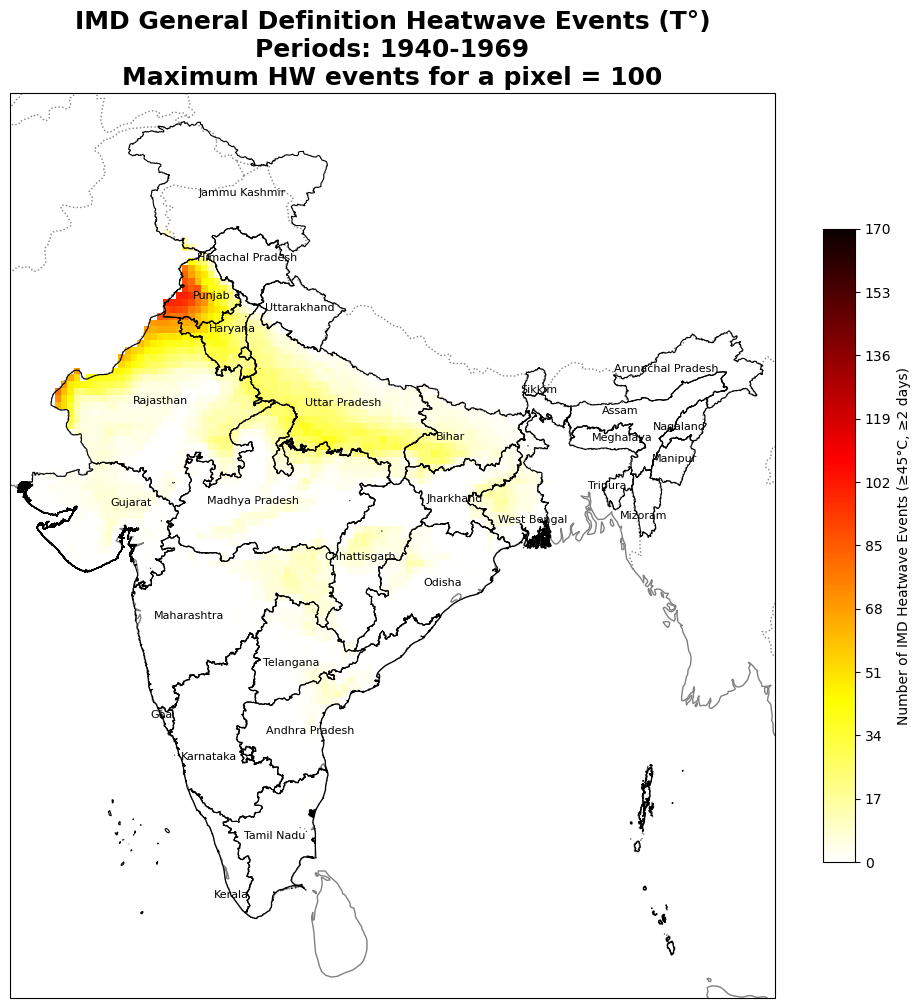

In [44]:
# Select the specific period on T
selected_period_1 = heatwave_bool_45_T.sel(time=slice('1940-01-01', '1969-12-31'))

# Count heatwave events
imd_1_heatwave_count_T = count_heatwave_events_imd_1(selected_period_1, min_streak=2)
print(imd_1_heatwave_count_T.max())

# Visualize (heatwave ≥ 45°C for ≥2 days)
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': ccrs.PlateCarree()})

# Map features
ax.add_feature(cfeature.BORDERS, linestyle=":", edgecolor="gray")
ax.add_feature(cfeature.COASTLINE, edgecolor="gray")
ax.add_feature(cfeature.LAND, facecolor="white")

# Add Indian states boundaries (if you have the shape file)
Indian_states.boundary.plot(ax=ax, edgecolor='black', linewidth=0.8)

# Plot city points and labels
for _, row in capitals_df.iterrows():
    #ax.plot(row["Longitude"], row["Latitude"], 'o', color='black', transform=ccrs.PlateCarree(), zorder=5)
    ax.text(row["Longitude"], row["Latitude"], row["State"],
            transform=ccrs.PlateCarree(), fontsize=8, color='black',
            horizontalalignment='center', verticalalignment='center', zorder=10)

# Color setup
cmap =plt.cm.hot_r
lon, lat = np.meshgrid(T_daily['longitude'], T_daily['latitude'])

# Plot
heatmap = ax.pcolormesh(lon, lat, imd_1_heatwave_count_T, cmap=cmap, shading='auto', vmin = 0, vmax = 170) 
cbar = plt.colorbar(heatmap, ax=ax, orientation="vertical", shrink=0.7, pad=0.05)
cbar.set_label("Number of IMD Heatwave Events (≥45°C, ≥2 days)")
cbar.set_ticks(np.linspace(0, 170, num=11))


plt.title(f"IMD General Definition Heatwave Events (T°)\nPeriods: 1940-1969\nMaximum HW events for a pixel = {imd_1_heatwave_count_T.max()}", fontsize=18, fontweight = 'bold')
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.tight_layout()
plt.show()

7.3.2 - HI daily max

In [42]:
# Select the specific period for severe heatwave on HI
selected_period_1 = heatwave_bool_45_HI.sel(time=slice('1940-01-01', '1969-12-31'))

imd_1_heatwave_count_HI = count_heatwave_events_imd_1(selected_period_1, min_streak=2)
print(imd_1_heatwave_count_HI.max())

238


395


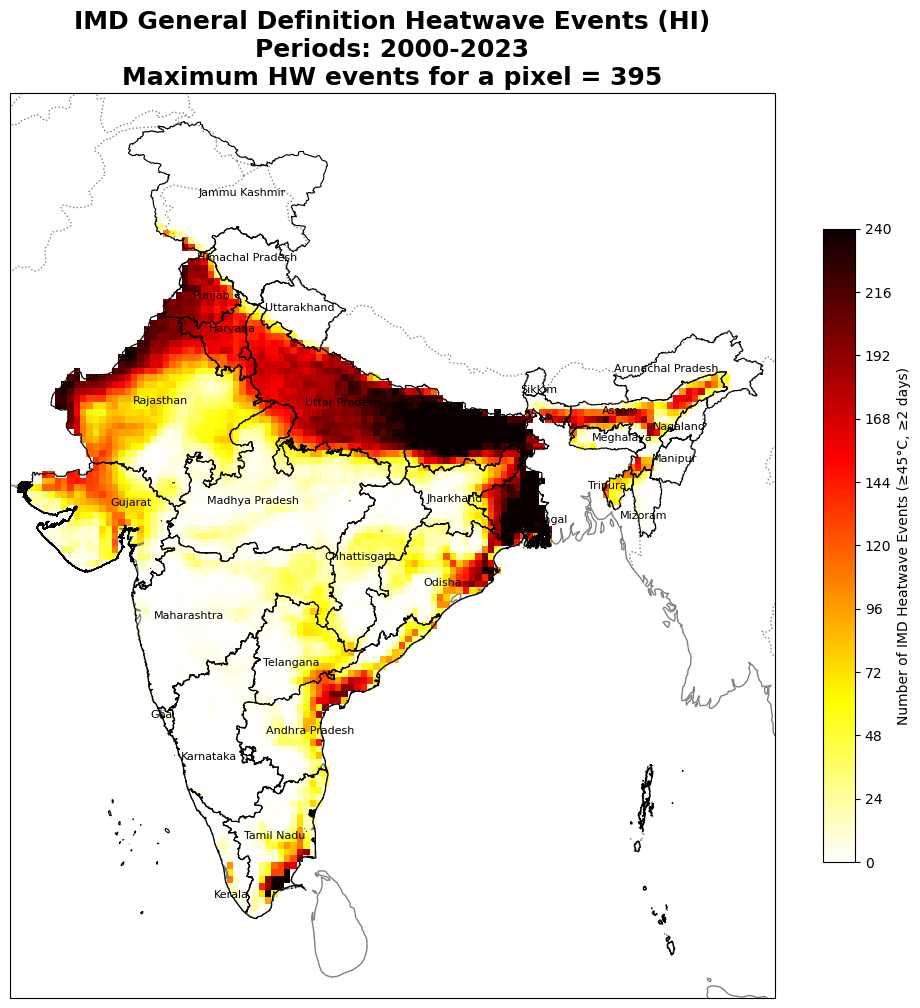

In [26]:
# Select the specific period on HI
selected_period_1 = heatwave_bool_45_HI.sel(time=slice('2000-01-01', '2023-12-31'))

# Count heatwave events
imd_1_heatwave_count_HI = count_heatwave_events_imd_1(selected_period_1, min_streak=2)
print(imd_1_heatwave_count_HI.max())

# Visualize (heatwave ≥ 45°C for ≥2 days)
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': ccrs.PlateCarree()})

# Map features
ax.add_feature(cfeature.BORDERS, linestyle=":", edgecolor="gray")
ax.add_feature(cfeature.COASTLINE, edgecolor="gray")
ax.add_feature(cfeature.LAND, facecolor="white")

# Add Indian states boundaries (if you have the shape file)
Indian_states.boundary.plot(ax=ax, edgecolor='black', linewidth=0.8)

# Plot city points and labels
for _, row in capitals_df.iterrows():
    #ax.plot(row["Longitude"], row["Latitude"], 'o', color='black', transform=ccrs.PlateCarree(), zorder=5)
    ax.text(row["Longitude"], row["Latitude"], row["State"],
            transform=ccrs.PlateCarree(), fontsize=8, color='black',
            horizontalalignment='center', verticalalignment='center', zorder=10)


# Color setup
cmap = plt.cm.hot_r
lon, lat = np.meshgrid(HI_daily['longitude'], HI_daily['latitude'])

# Plot
heatmap = ax.pcolormesh(lon, lat, imd_1_heatwave_count_HI, cmap=cmap, shading='auto', vmin = 0, vmax = 240) 
cbar = plt.colorbar(heatmap, ax=ax, orientation="vertical", shrink=0.7, pad=0.05)
cbar.set_label("Number of IMD Heatwave Events (≥45°C, ≥2 days)")
cbar.set_ticks(np.linspace(0, 240, num=11))


plt.title(f"IMD General Definition Heatwave Events (HI)\nPeriods: 2000-2023\nMaximum HW events for a pixel = {imd_1_heatwave_count_HI.max()}", fontsize=18, fontweight = 'bold')
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.tight_layout()
plt.show()

7.3.3 - T daily max severe HW

In [ ]:
# Select the specific period for severe heatwave on T
selected_period_2 = heatwave_bool_47_T.sel(time=slice('1940-01-01', '2023-12-31'))

imd_1_hw_severe_count_T = count_heatwave_events_imd_1(selected_period_2, min_streak=2)
print(imd_1_hw_severe_count_T.max())

65


65


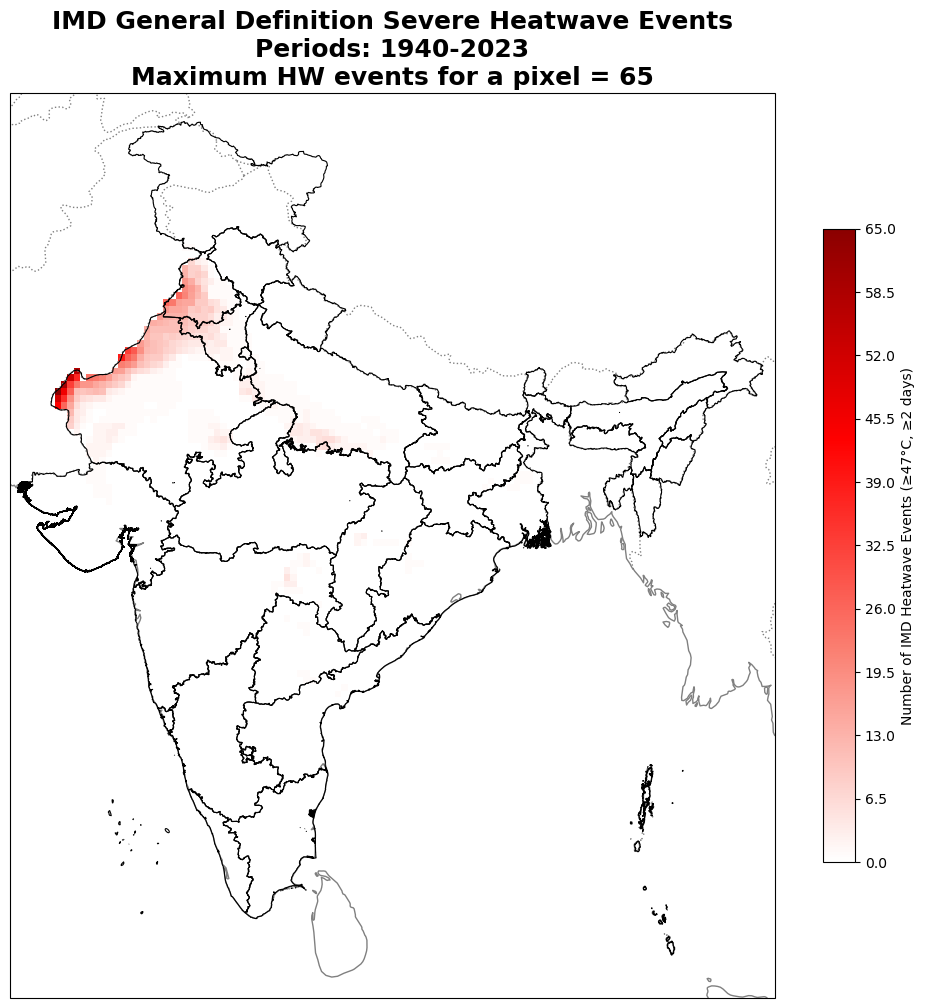

In [ ]:
# Select the specific period on T
selected_period_2 = heatwave_bool_47_T.sel(time=slice('1940-01-01', '2023-12-31'))

# Count severe heatwave events
imd_1_hw_severe_count_T = count_heatwave_events_imd_1(selected_period_2, min_streak=2)
print(imd_1_hw_severe_count_T.max())

# Visualize (heatwave ≥ 45°C for ≥2 days)
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': ccrs.PlateCarree()})

# Map features
ax.add_feature(cfeature.BORDERS, linestyle=":", edgecolor="gray")
ax.add_feature(cfeature.COASTLINE, edgecolor="gray")
ax.add_feature(cfeature.LAND, facecolor="white")

# Add Indian states boundaries (if you have the shape file)
Indian_states.boundary.plot(ax=ax, edgecolor='black', linewidth=0.8)


# Color setup
cmap = LinearSegmentedColormap.from_list("hw_cmap", ["white", "salmon", "red", "darkred"])
lon, lat = np.meshgrid(T_daily['longitude'], T_daily['latitude'])

# Plot
heatmap = ax.pcolormesh(lon, lat, imd_1_hw_severe_count_T, cmap=cmap, shading='auto', vmin = 0, vmax = 65)
cbar = plt.colorbar(heatmap, ax=ax, orientation="vertical", shrink=0.7, pad=0.05)
cbar.set_label("Number of IMD Heatwave Events (≥47°C, ≥2 days)")
cbar.set_ticks(np.linspace(0, 65, num=11))


plt.title(f"IMD General Definition Severe Heatwave Events\nPeriods: 1940-2023\nMaximum HW events for a pixel = {imd_1_hw_severe_count.max()}", fontsize=18, fontweight = 'bold')
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.tight_layout()
plt.show()

7.3.4 - HI daily max severe HW

In [50]:
# Select the specific period for severe heatwave HI
selected_period_2 = heatwave_bool_47_HI.sel(time=slice('1940-01-01', '2023-12-31'))

imd_1_hw_severe_count_HI = count_heatwave_events_imd_1(selected_period_2, min_streak=2)
print(imd_1_hw_severe_count_HI.max())

476


476


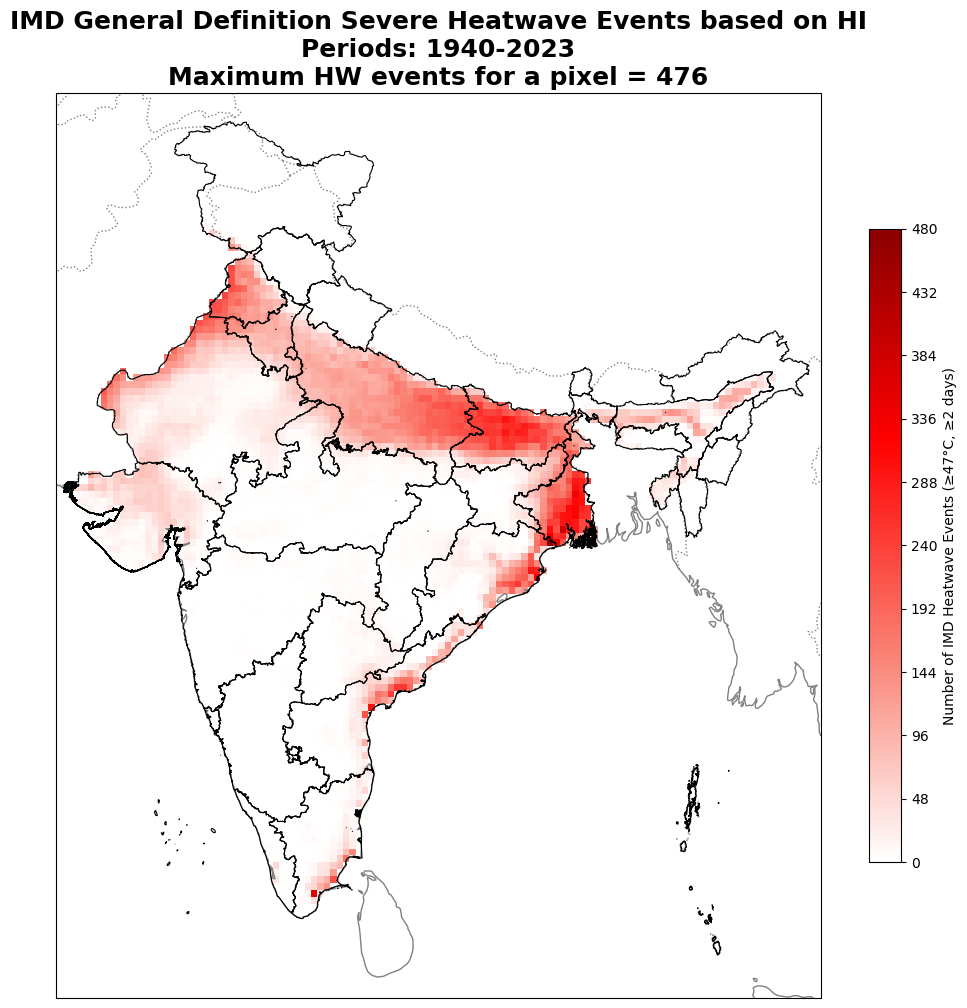

In [ ]:
# Select the specific period HI
selected_period_2 = heatwave_bool_47_HI.sel(time=slice('1940-01-01', '2023-12-31'))

# Count severe heatwave events
imd_1_hw_severe_count_HI = count_heatwave_events_imd_1(selected_period_2, min_streak=2)
print(imd_1_hw_severe_count_HI.max())

# Visualize (heatwave ≥ 45°C for ≥2 days)
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': ccrs.PlateCarree()})

# Map features
ax.add_feature(cfeature.BORDERS, linestyle=":", edgecolor="gray")
ax.add_feature(cfeature.COASTLINE, edgecolor="gray")
ax.add_feature(cfeature.LAND, facecolor="white")

# Add Indian states boundaries (if you have the shape file)
Indian_states.boundary.plot(ax=ax, edgecolor='black', linewidth=0.8)


# Color setup
cmap = LinearSegmentedColormap.from_list("hw_cmap", ["white", "salmon", "red", "darkred"])
lon, lat = np.meshgrid(T_daily['longitude'], T_daily['latitude'])

# Plot
heatmap = ax.pcolormesh(lon, lat, imd_1_hw_severe_count_HI, cmap=cmap, shading='auto', vmin = 0, vmax = 480)
cbar = plt.colorbar(heatmap, ax=ax, orientation="vertical", shrink=0.7, pad=0.05)
cbar.set_label("Number of IMD Heatwave Events (≥47°C, ≥2 days)")
cbar.set_ticks(np.linspace(0, 480, num=11))


plt.title(f"IMD General Definition Severe Heatwave Events based on HI\nPeriods: 1940-2023\nMaximum HW events for a pixel = {imd_1_hw_severe_count_HI.max()}", fontsize=18, fontweight = 'bold')
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.tight_layout()
plt.show()

7.3.5 - Warm nights

Warm nights are determined by the maximum temperature >= 40°C and if the deviation is between 4.5°C and 6.4 °C of the daily minimum temperature as compared to the normal daily minimum temperature. Furthermore, IMD considers a night to be very warm if the deviation of the minimum temperature exceeds 6.4°C.

In [6]:
# Extract 1991–2020 baseline period on T
baseline_min_T_imd = T_daily['daily_min_temp'].sel(time=slice('1991-01-01', '2020-12-31'))

# Group by day-of-year and take the mean (climatology)
baseline_imd_average_min_T = baseline_min_T_imd.mean(dim='time')

In [7]:
# Extract 1991–2020 baseline period on HI
baseline_min_HI_imd = HI_daily['daily_min_HI'].sel(time=slice('1991-01-01', '2020-12-31'))

# Group by day-of-year and take the mean (climatology)
baseline_imd_average_min_HI = baseline_min_HI_imd.mean(dim='time')

In [8]:
diff_min_T_imd = T_daily['daily_min_temp'] - baseline_imd_average_min_T

In [9]:
diff_min_HI_imd =  HI_daily['daily_min_HI'] - baseline_imd_average_min_HI

In [10]:
# Binary warm nights conditions on T
warm_nights_T = (T_daily['daily_min_temp'] >= 40) & (diff_min_T_imd >= 4.5) & (diff_min_T_imd <= 6.4)
warm_nights_bool_T = warm_nights_T.astype(int)
warm_nights_bool_T.max()

<xarray.DataArray 'daily_min_temp' ()>
array(0)

In [11]:
# Binary warm nights conditions on HI
warm_nights_HI = (HI_daily['daily_min_HI'] >= 40) & (diff_min_HI_imd >= 4.5) & (diff_min_HI_imd <= 6.4)
warm_nights_bool_HI = warm_nights_HI.astype(int)
warm_nights_bool_HI.max()

<xarray.DataArray 'daily_min_HI' ()>
array(0)

In [12]:
def count_warm_nights_imd(bool_array, min_days=1):
    def count_streaks(arr):
        count = 0
        streak = 0
        for val in arr:
            if val:
                streak += 1
            else:
                if streak >= min_days:
                    count += 1
                streak = 0
        if streak >= min_days:
            count += 1
        return count

    return np.apply_along_axis(count_streaks, axis=0, arr=bool_array)

In [16]:
# Select the specific period on T
selected_period = warm_nights_bool_T.sel(time=slice('1940-01-01', '2023-12-31'))

warm_nights_count_T = count_warm_nights_imd(selected_period, min_days = 1)
print(warm_nights_count_T.max())

0


In [15]:
# Select the specific period on HI
selected_period = warm_nights_bool_HI.sel(time=slice('1940-01-01', '2023-12-31'))

warm_nights_count_HI = count_warm_nights_imd(selected_period, min_days = 1)
print(warm_nights_count_HI.max())

0


0


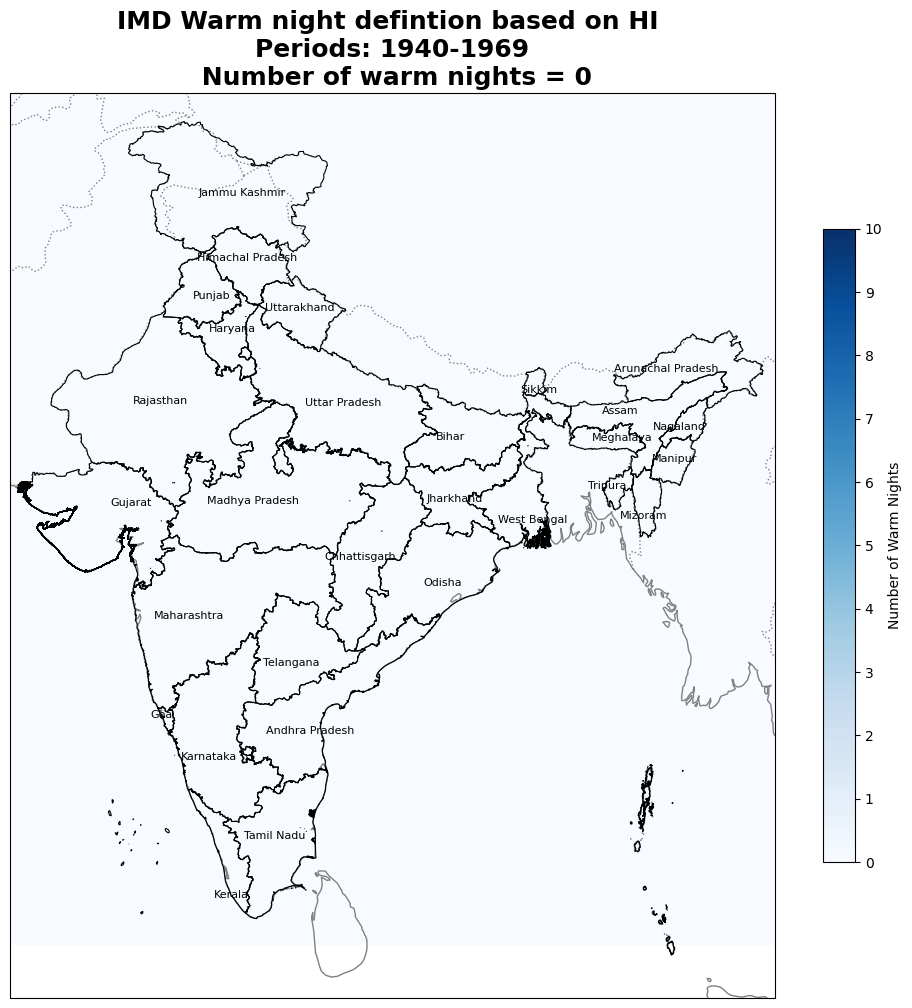

In [56]:
# Select the specific period on HI
selected_period = warm_nights_bool_HI.sel(time=slice('1940-01-01', '1969-12-31'))

warm_nights_count_HI = count_warm_nights_imd(selected_period, min_days=1)
print(warm_nights_count_HI.max())

fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': ccrs.PlateCarree()})

# Map features
ax.add_feature(cfeature.BORDERS, linestyle=":", edgecolor="gray")
ax.add_feature(cfeature.COASTLINE, edgecolor="gray")
ax.add_feature(cfeature.LAND, facecolor="white")

# Add Indian states boundaries (if you have the shape file)
Indian_states.boundary.plot(ax=ax, edgecolor='black', linewidth=0.8)

# Plot city points and labels
for _, row in capitals_df.iterrows():
    #ax.plot(row["Longitude"], row["Latitude"], 'o', color='black', transform=ccrs.PlateCarree(), zorder=5)
    ax.text(row["Longitude"], row["Latitude"], row["State"],
            transform=ccrs.PlateCarree(), fontsize=8, color='black',
            horizontalalignment='center', verticalalignment='center', zorder=10)

# Longitude & Latitude for mesh
lon, lat = np.meshgrid(HI_daily['longitude'], HI_daily['latitude'])

# Plot the data
heatmap = ax.pcolormesh(lon, lat, warm_nights_count_HI, cmap='Blues', shading='auto', vmin=0, vmax = 10)

# Colorbar
cbar = plt.colorbar(heatmap, ax=ax, orientation="vertical", shrink=0.7, pad=0.05)
cbar.set_label(f"Number of Warm Nights")
cbar.set_ticks(np.linspace(0, 10, num=11))

# Add title and labels
plt.title(f"IMD Warm night defintion based on HI \nPeriods: 1940-1969\n Number of warm nights = {warm_nights_count_HI.max()}", fontsize=18, fontweight = 'bold')
plt.xlabel("Longitude")
plt.ylabel("Latitude")


plt.tight_layout()
plt.show()

7.3.6 - IMD regional definition --> to keep or remove?

India Meteorological Department has 3 main definitions based on the geographical locations in India, hilly, plain and coastal (Home | India Meteorological Department, 2021; Deoras, 2016):

•	Hilly regions: daily maximum temperature >= 30°C with a daily maximum deviation of 4.5°C to 6.4°C compared to the normal daily maximum temperature for 2 consecutive days by at least 2 IMD stations in the same metrological subdivision.

•	Plain regions: daily maximum temperature >= 40°C with a daily maximum deviation of 4.5°C to 6.4°C with reference to normal daily maximum temperature for 2 consecutive days by at least 2 IMD stations in the same metrological subdivision.

•	Coastal regions: 37°C >= daily maximum temperature with a daily maximum deviation of 4.5°C with reference to normal daily maximum temperature for 2 consecutive days by at least 2 IMD stations in the same metrological subdivision.

If the deviation exceeds 6.4°C, this categorizes into “severe heatwave”. With the normal daily maximum temperature determined by the climatology of maximum temperature for the period 1991 to 2020 for each day (Home | India Meteorological Department, 2021; Deoras, 2016).

In [7]:
# Extract 1991–2020 baseline period
baseline_imd = T_daily['daily_max_temp'].sel(time=slice('1991-01-01', '2020-12-31'))

# Group by day-of-year and take the mean (climatology)
baseline_imd_average_max_T = baseline_imd.mean(dim='time')

In [8]:
diff_T_imd = T_daily['daily_max_temp'] - baseline_imd_average_max_T

In [9]:
def count_heatwave_events_imd_regions(bool_array, min_days=2):
    def count_streaks(arr):
        count = 0
        streak = 0
        for val in arr:
            if val:
                streak += 1
            else:
                if streak >= min_days:
                    count += 1
                streak = 0
        if streak >= min_days:
            count += 1
        return count

    return np.apply_along_axis(count_streaks, axis=0, arr=bool_array)


In [10]:
# Define the 3 regions
lat = T_daily['latitude']
lon = T_daily['longitude']

# Create rough masks for regions (adjust as needed)
hilly_mask = ((lat > 28) | (lon > 87)) & ((lat < 38) | (lon < 97)) # Simplified: Himalayas/north
coastal_mask = ((lon < 75) | (lon > 85)) & (lat < 20)  # Rough coastal guess
plains_mask = ~(hilly_mask | coastal_mask)  # Remaining areas

# Expand dims to match (lat, lon)
hilly_mask = hilly_mask.broadcast_like(T_daily['daily_max_temp'].isel(time=0))
coastal_mask = coastal_mask.broadcast_like(hilly_mask)
plains_mask = plains_mask.broadcast_like(hilly_mask)

In [11]:
# Create boolean masks for heatwave conditions per region
T = T_daily['daily_max_temp']
anom = diff_T_imd

lat = T_daily['latitude']
lon = T_daily['longitude']

In [12]:
# Hilly region
hilly_mask =  (lon > 89)

# Heatwave
hilly_hw = (T >= 30) & (anom >= 4.5) & (anom <= 6.4) & hilly_mask
hilly_hw_bool = hilly_hw.astype(int)

# Severe heatwave
hilly_hw_severe = (T >= 30) & (anom > 6.4) & hilly_mask
hilly_hw_severe_bool = hilly_hw_severe.astype(int)

# Select the specific period
selected_period = hilly_hw_bool.sel(time=slice('1940-01-01', '1969-12-31'))

imd_hw_hilly = count_heatwave_events_imd_regions(selected_period, min_days = 2)
print(imd_hw_hilly.max())

# Select the specific period
selected_period = hilly_hw_severe_bool.sel(time=slice('1940-01-01', '1969-12-31'))

imd_hw_severe_hilly = count_heatwave_events_imd_regions(selected_period, min_days = 2)
print(imd_hw_severe_hilly.max())

151
78


192


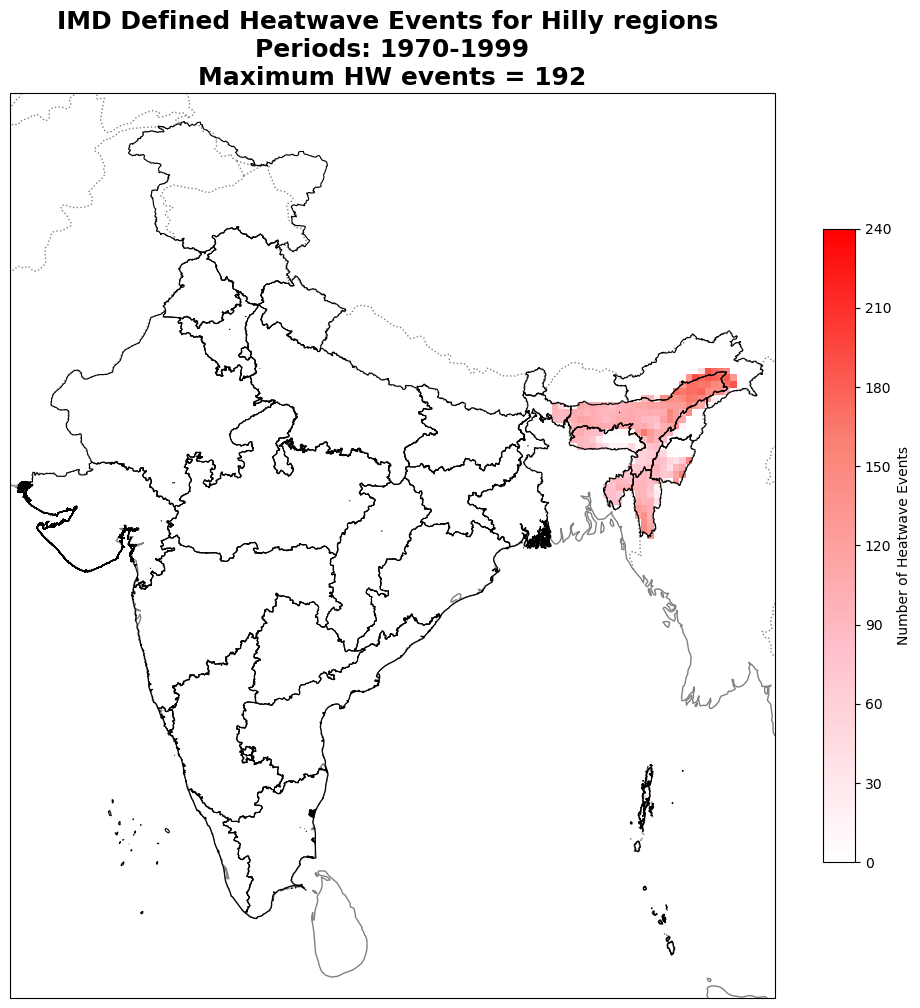

In [30]:
# Select the specific period
selected_period = hilly_hw_bool.sel(time=slice('1970-01-01', '1999-12-31'))

imd_heatwaves_hilly = count_heatwave_events_imd_regions(selected_period, min_days = 2)
print(imd_heatwaves_hilly.max())

fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': ccrs.PlateCarree()})

# Map features
ax.add_feature(cfeature.BORDERS, linestyle=":", edgecolor="gray")
ax.add_feature(cfeature.COASTLINE, edgecolor="gray")
ax.add_feature(cfeature.LAND, facecolor="white")

# Add Indian states boundaries (if you have the shape file)
Indian_states.boundary.plot(ax=ax, edgecolor='black', linewidth=0.8)


# Longitude & Latitude for mesh
lon, lat = np.meshgrid(T_daily['longitude'], T_daily['latitude'])

# Plot the data
cmap = LinearSegmentedColormap.from_list("hw_cmap", ["white", "pink", "salmon", "red"])
heatmap = ax.pcolormesh(lon, lat, imd_heatwaves_hilly, cmap=cmap, shading='auto', vmin = 0, vmax = 240)

# Colorbar
cbar = plt.colorbar(heatmap, ax=ax, orientation="vertical", shrink=0.7, pad=0.05)
cbar.set_label(f"Number of Heatwave Events")
cbar.set_ticks(np.linspace(0, 240, num=9))

# Add title and labels
plt.title(f"IMD Defined Heatwave Events for Hilly regions \nPeriods: 1970-1999\nMaximum HW events = {imd_heatwaves_hilly.max()}", fontsize=18, fontweight = 'bold')
plt.xlabel("Longitude")
plt.ylabel("Latitude")


plt.tight_layout()
plt.show()


86


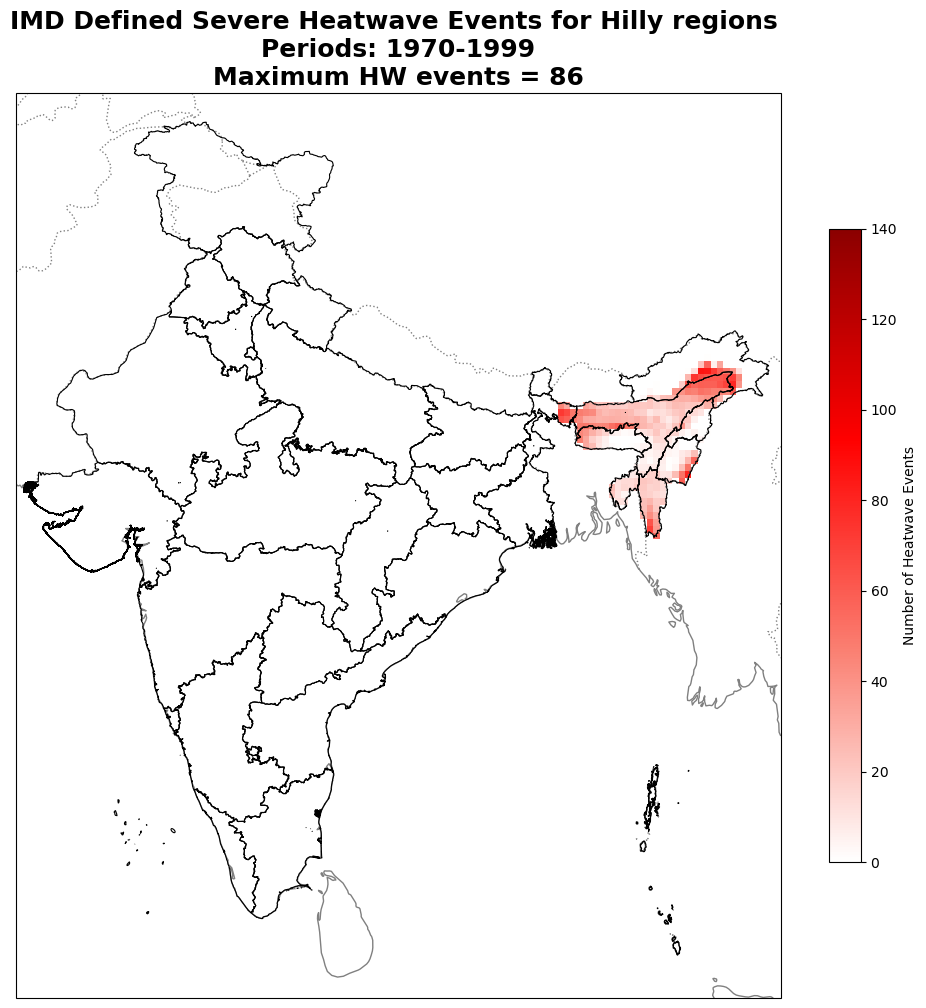

In [33]:
# Select the specific period
selected_period = hilly_hw_severe_bool.sel(time=slice('1970-01-01', '1999-12-31'))

imd_hw_severe_hilly = count_heatwave_events_imd_regions(selected_period, min_days = 2)
print(imd_hw_severe_hilly.max())

fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': ccrs.PlateCarree()})

# Map features
ax.add_feature(cfeature.BORDERS, linestyle=":", edgecolor="gray")
ax.add_feature(cfeature.COASTLINE, edgecolor="gray")
ax.add_feature(cfeature.LAND, facecolor="white")

# Add Indian states boundaries (if you have the shape file)
Indian_states.boundary.plot(ax=ax, edgecolor='black', linewidth=0.8)


# Longitude & Latitude for mesh
lon, lat = np.meshgrid(T_daily['longitude'], T_daily['latitude'])

# Plot the data
cmap = LinearSegmentedColormap.from_list("hw_cmap", ["white", "salmon", "red", "darkred"])
heatmap = ax.pcolormesh(lon, lat, imd_hw_severe_hilly, cmap=cmap, shading='auto', vmin=0, vmax = 140)

# Colorbar
cbar = plt.colorbar(heatmap, ax=ax, orientation="vertical", shrink=0.7, pad=0.05)
cbar.set_label(f"Number of Heatwave Events")

# Add title and labels
plt.title(f"IMD Defined Severe Heatwave Events for Hilly regions \nPeriods: 1970-1999\nMaximum HW events = {imd_hw_severe_hilly.max()}", fontsize=18, fontweight = 'bold')
plt.xlabel("Longitude")
plt.ylabel("Latitude")


plt.tight_layout()
plt.show()

In [ ]:
# Create boolean masks for heatwave conditions per region
T = T_daily['daily_max_temp']
anom = diff_T_imd

# Core thresholds for each region
hilly_hw = (T >= 30) & (anom >= 4.5) & (anom <= 6.4) & hilly_mask
plains_hw = (T >= 40) & (anom >= 4.5) & (anom <= 6.4)
coastal_hw = (T >= 37) & (anom >= 4.5) 

# Combine regional HW definitions
heatwave_day = (hilly_hw | plains_hw | coastal_hw)

# Severe and extreme events
severe_hw = (anom > 6.4)
extreme_hw = (T >= 45)

hilly_bool = hilly_hw.astype(int)
coastal_bool = coastal_hw.astype(int)
plains_bool = plains_hw.astype(int)

In [241]:
# Binary heatwave conditions
heatwave_bool_imd = heatwave_day.astype(int)
heatwave_bool_imd

<xarray.DataArray (time: 30681, latitude: 124, longitude: 120)>
array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
...
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]])
Coordinates:
  * longitude  (longitude) float32 68.0 68.25 68.5 68.75 ... 97.25 97.5 97.75
  * latitude   (latitude) float32 38.0 37.75 37.5 37.25 ... 8.0 7.75 7.5 7.25
  * time       (time) datetime64[ns] 1940-01-01 1940-01-02 ... 2023-12-31

In [ ]:
imd_heatwave_count = count_heatwave_events_imd_regions(heatwave_bool_imd, min_days=2)
imd_heatwave_count.max()

924